In [1]:
import matplotlib.pyplot as plt
import mlflow
import pandas as pd

from freeholdforecast.tasks.etl_ml_task import ETL_ML_Task
from sklearn.inspection import permutation_importance

max_view = 400
pd.options.display.max_rows = max_view
pd.options.display.max_columns = max_view

state = "ohio"
run_date = "2022-03-01"

task = ETL_ML_Task(state=state, run_date=run_date)

2023-06-02 18:00:12 INFO ETL_ML_Task Initializing task for ohio with run date 2022-03-01
2023-06-02 18:00:12 INFO ETL_ML_Task Train dates: 2020-09-01 to 2021-09-30
2023-06-02 18:00:12 INFO ETL_ML_Task Test date: 2022-03-01
2023-06-02 18:00:12 INFO ETL_ML_Task Prediction period: 2022-04-01 to 2022-06-30
2023-06-02 18:00:12 INFO ETL_ML_Task Min months since last sale: 10
2023-06-02 18:00:12 INFO ETL_ML_Task Max months since last sale: 20
2023-06-02 18:00:12 INFO ETL_ML_Task Classification probability threshold: 0.7


In [2]:
task._get_df_raw()

2023-06-02 18:00:12 INFO ETL_ML_Task Loading existing raw data
2023-06-02 18:00:34 INFO ETL_ML_Task Total raw parcels: 354573
2023-06-02 18:00:34 INFO ETL_ML_Task Total raw sales: 1048377
2023-06-02 18:00:35 INFO ETL_ML_Task No predictions to update


In [4]:
task._get_df_encoded()

2023-06-02 18:00:35 INFO ETL_ML_Task Loading existing encoded data
2023-06-02 18:00:35 INFO ETL_ML_Task Total encoded parcels: 354573
2023-06-02 18:00:35 INFO ETL_ML_Task Total encoded sales: 1048377


In [6]:
task._get_df_prepared()

2023-06-02 18:00:35 INFO ETL_ML_Task Loading existing prepared data
2023-06-02 18:00:42 INFO ETL_ML_Task Splitting data


In [8]:
task.df_prepared.describe().astype(str)

,sale_in_3_months,sale_in_6_months,sale_in_12_months,next_sale_price,total_sales,month,months_since_last_sale,months_since_last_sale_max,Parid,PropertyAddressFull,PropertyAddressCity,SitusCounty,SitusStateCode,NeighborhoodCode,PartyOwner1NameFull,CompanyFlag,OwnerTypeDescription1,PropertyUseGroup,YearBuilt,PropertyAddressZIP,PropertyLatitude,PropertyLongitude,BathCount,BathPartialCount,BedroomsCount,AreaBuilding,AreaLotSF,StoriesCount,TaxMarketValueLand,TaxMarketValueImprovements,TaxMarketValueTotal,EstimatedValue,ConfidenceScore,YearBuiltRounded,AreaBuildingRounded,AreaLotSFRounded,TaxMarketValueLandRounded,TaxMarketValueImprovementsRounded,TaxMarketValueTotalRounded,EstimatedValueRounded,last_sale_priceRounded,business_owner,next_business_owner,same_owner,next_same_owner,good_sale,next_good_sale,last_sale_price,months_since_year_built
count,5589995.0,5589995.0,5589995.0,434776.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5586925.0,5589963.0,5589963.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5158063.0,5158063.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5589995.0,5158063.0,3941946.0,5589995.0,536557.0,5589995.0,536557.0,5589995.0,536557.0,4080229.0,5589963.0
mean,0.019030428470866254,0.035957813915754845,0.06363279394704288,258033.2815909802,2.362927516035345,6.509848756573128,22.09984695871821,18.90243103974154,178645.37647672315,177030.25465353727,22.123489377003022,1.323922472202569,0.0,307.4990805895175,177966.82343687248,0.947814443483402,1.2426356374200693,4.884840863006139,1960.3867874658206,45160.87713670758,39.232794503699736,-84.45976465921419,2.1833718098137833,0.4827428289291851,3.193904466819738,1865.475805971204,51878.01596996777,1.5081172702301164,47146.08940079553,138379.72678508656,185525.8161858821,265782.9138729015,77.30151279656724,1960.4951471334052,1863.8338674721533,51824.87551419992,47350.825000737925,138358.8446859076,185586.373511962,265754.34421797487,157726.97038467802,0.029061743346818734,0.13824999021539183,0.2928957897100087,0.48008506086026276,0.7071042102899913,0.5199149391397373,158622.55708025213,61.612277219008426
std,0.13663189452931007,0.18618500405614505,0.24409766926482712,300273.2089976643,0.9894548613773355,3.638790515811865,13.535289714827224,5.154034602422983,99836.46646062366,102179.67273723277,17.62299153394429,0.8650904976919206,0.0,311.9600192396416,89005.84023061019,0.22240106352263952,0.5367818453075193,0.6921413515798892,31.37493124857306,90.16000928769506,0.13036083104021695,0.15100869006916248,1.1422394883935127,0.5682839767845728,1.0534405476052646,2393.505497085955,3024406.019068826,0.5081010938887192,82026.61904020987,206200.64401897136,257867.1682566201,132392.4009813501,10.110868142747272,31.47953233119304,2398.2507305378062,3024406.464784419,82249.05990733516,206342.50413129726,257950.4494289884,132629.89943989282,268192.2496935102,0.16797965194707362,0.34516250152776345,0.4550910712482753,0.4996037033434432,0.4550910712482753,0.4996037033434431,273895.097405042,31.37258559594909
min,0.0,0.0,0.0,1.0,1.0,1.0,10.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1797.0,45001.0,38.772478,-84.820315,0.5,0.0,1.0,72.0,4.0,1.0,0.0,0.0,12520.0,44010.0,50.0,1800.0,0.0,0.0,0.0,0.0,25000.0,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0
25%,0.0,0.0,0.0,125681.0,2.0,3.0,14.0,14.0,93605.0,88105.0,12.0,0.0,0.0,0.0,98819.0,1.0,1.0,5.0,1942.0,45069.0,39.143625,-84.572264,1.0,0.0,3.0,1232.0,7388.0,1.0,22200.0,67780.0,92530.0,169800.0,71.0,1940.0,1000.0,5000.0,25000.0,75000.0,100000.0,175000.0,75000.0,0.0,0.0,0.0,0.0,0.0,0.0,79000.0,36.0
50%,0.0,0.0,0.0,200000.0,2.0,7.0,19.0,19.0,178851.0,177704.0,12.0,2.0,0.0,410.0,196699.0,1.0,1.0,5.0,1962.0,45212.0,39.213891,-84.467362,2.0,0.0,3.0,1636.0,12197.0,2.0,33300.0,110940.0,147080.0,237100.0,80.0,1960.0,1500.0,10000.0,25000.0,100000.0,150000.0,225000.0,125000.0,0.0,0.0,0.0,0.0,1.0,1.0,125

In [9]:
df_corr = task.df_prepared.loc[
    (task.df_prepared.date >= task.train_start_date)
    & (task.df_prepared.date <= task.train_end_date)
    & (task.df_prepared.months_since_last_sale >= task.min_months_since_last_sale)
    & (task.df_prepared.months_since_last_sale <= task.max_months_since_last_sale)
    & ((task.df_prepared.next_good_sale.isna()) | (task.df_prepared.next_good_sale == 1))
].corr()
df_corr.loc[df_corr.sale_in_3_months.abs() > 0.005]


,sale_in_3_months,sale_in_6_months,sale_in_12_months,next_sale_price,total_sales,month,months_since_last_sale,months_since_last_sale_max,Parid,PropertyAddressFull,PropertyAddressCity,SitusCounty,SitusStateCode,NeighborhoodCode,PartyOwner1NameFull,CompanyFlag,OwnerTypeDescription1,PropertyUseGroup,YearBuilt,PropertyAddressZIP,PropertyLatitude,PropertyLongitude,BathCount,BathPartialCount,BedroomsCount,AreaBuilding,AreaLotSF,StoriesCount,TaxMarketValueLand,TaxMarketValueImprovements,TaxMarketValueTotal,EstimatedValue,ConfidenceScore,YearBuiltRounded,AreaBuildingRounded,AreaLotSFRounded,TaxMarketValueLandRounded,TaxMarketValueImprovementsRounded,TaxMarketValueTotalRounded,EstimatedValueRounded,last_sale_priceRounded,business_owner,next_business_owner,same_owner,next_same_owner,good_sale,next_good_sale,last_sale_price,months_since_year_built
sale_in_3_months,1.000000,0.700102,0.491932,-0.014552,-0.011973,-0.001898,0.004178,0.004178,-0.000058,-0.005133,0.003446,-0.007736,NaN,0.006970,0.005419,-0.038181,-0.012758,-0.014132,0.001256,-0.009383,0.001634,0.003475,0.004018,-0.008077,-0.001069,0.004549,0.000458,-0.003958,0.004530,0.006287,0.006459,-0.004994,-0.014046,0.000987,0.004575,0.000459,0.004353,0.006218,0.006498,-0.004982,-0.001536,0.045298,0.007333,-0.000376,NaN,0.000376,NaN,-0.001608,-0.001253
sale_in_6_months,0.700102,1.000000,0.702657,-0.024100,-0.016423,-0.001657,0.005779,0.005779,-0.000494,-0.006256,0.005148,-0.011000,NaN,0.009822,0.006875,-0.051169,-0.018166,-0.019674,0.002099,-0.013030,0.002375,0.004569,0.005427,-0.011696,-0.002494,0.006060,0.000692,-0.006077,0.006855,0.008465,0.008934,-0.007449,-0.020134,0.001674,0.006098,0.000693,0.006685,0.008386,0.008980,-0.007513,-0.001728,0.065922,0.000410,0.000463,NaN,-0.000463,NaN,-0.001884,-0.002095
sale_in_12_months,0.491932,0.702657,1.000000,-0.002227,-0.021779,0.000024,0.008189,0.008189,-0.003344,-0.007375,0.004237,-0.013586,NaN,0.012412,0.005482,-0.063562,-0.024764,-0.026434,0.004919,-0.015723,0.000935,0.005928,0.006555,-0.014196,-0.005881,0.007910,0.000990,-0.009955,0.010887,0.010957,0.012197,-0.009308,-0.023981,0.004161,0.007908,0.000990,0.010725,0.010829,0.012250,-0.009449,0.000734,0.090226,-0.012763,0.001845,NaN,-0.001845,NaN,0.000478,-0.004914
next_sale_price,-0.014552,-0.024100,-0.002227,1.000000,-0.143241,-0.003018,-0.070513,-0.070513,-0.039573,0.145427,0.017044,0.047789,NaN,-0.089926,0.089095,-0.013149,0.045956,-0.153733,0.157792,0.099927,-0.046502,0.083713,0.096895,0.176852,0.024580,0.432638,0.083490,0.117333,0.648674,0.510192,0.573855,0.617317,0.213335,0.157581,0.434416,0.083714,0.648287,0.509814,0.574646,0.616643,0.221931,0.096986,0.163478,-0.031544,NaN,0.031544,NaN,0.237235,-0.157792
total_sales,-0.011973,-0.016423,-0.021779,-0.143241,1.000000,-0.003376,-0.213947,-0.213947,0.084050,-0.019185,0.106961,-0.166711,NaN,0.152492,-0.040409,-0.046114,-0.059210,0.012352,-0.221220,-0.117376,0.100252,0.059470,-0.139705,-0.090180,-0.077082,-0.049952,-0.003523,-0.079827,-0.071962,-0.092330,-0.096564,-0.199923,-0.098050,-0.214430,-0.050078,-0.003525,-0.071814,-0.092371,-0.096404,-0.199517,-0.064666,0.079114,-0.039265,0.616950,NaN,-0.616950,NaN,-0.067688,0.221230
PropertyAddressFull,-0.005133,-0.006256,-0.007375,0.145427,-0.019185,0.000319,0.011942,0.011942,0.085982,1.000000,0.157208,-0.082332,NaN,0.002674,-0.002164,0.012627,0.004171,-0.018378,0.120770,-0.006125,0.042198,0.043209,0.099329,0.084216,0.061739,0.029473,0.006637,0.009732,0.074847,0.055658,0.068102,0.162285,0.182769,0.121031,0.029480,0.006630,0.075526,0.055679,0.068302,0.162117,0.053663,-0.032399,-0.021587,0.014149,NaN,-0.014149,NaN,0.055157,-0.120826
SitusCounty,-0.007736,-0.011000,-0.013586,0.047789,-0.166711,-0.000246,-0.043880,-0.043880,-0.614529,-0.082332,-0.618970,1.000000,NaN,-0.842901,0.037139,-0.031235,0.031003,0.094952,-0.264939,0.857672,-0.668183,-0.135637,-0.033964,-0.000601,-0.022517,-0.015514,-0.005435,0.086983,0.023900,-0.002272,0.005693,-0.001870,-0.226363,-0.261881,-0.015028,-0.005438,0.024003,-0.002147

In [11]:
task.df_train_classification.describe(include="all").astype(str)

,sale_in_3_months,next_sale_price,sale_in_6_months,sale_in_12_months,total_sales,CompanyFlag,OwnerTypeDescription1,PropertyUseGroup,BathPartialCount,StoriesCount,ConfidenceScore,TaxMarketValueTotalRounded,business_owner
count,26911.0,1540.0,26911.0,26911.0,26911.0,26911.0,26911.0,26911.0,26911.0,26911.0,23041.0,26911.0,26911.0
mean,0.04455427148749582,439869.1655844156,0.0895916168109695,0.14421611980231133,2.830552562149307,0.8052840845750808,1.0988443387462377,4.755155884210917,0.5902047489874029,1.5612574783545763,75.64103120524283,272318.9402103229,0.10456690572628294
std,0.20632685304960457,765835.8234643037,0.28560110300207125,0.3513152671176812,1.3747918957873002,0.3959892102012586,0.6917541094995218,0.9822982122641685,0.6895401009315967,0.5292193281122525,11.15887859847299,526787.1075589337,0.30600024089525474
min,0.0,1000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,50.0,25000.0,0.0
25%,0.0,151000.0,0.0,0.0,2.0,1.0,1.0,5.0,0.0,1.0,68.0,100000.0,0.0
50%,0.0,315000.0,0.0,0.0,3.0,1.0,1.0,5.0,0.0,2.0,78.0,175000.0,0.0
75%,0.0,512362.5,0.0,0.0,4.0,1.0,2.0,5.0,1.0,2.0,85.0,325000.0,0.0
max,1.0,13333333.0,1.0,1.0,11.0,1.0,2.0,6.0,20.0,9.0,96.0,21450000.0,1.0


In [12]:
task.df_train_regression.describe(include="all").astype(str)

,sale_in_3_months,next_sale_price,sale_in_6_months,sale_in_12_months,PropertyUseGroup,YearBuiltRounded,AreaBuildingRounded,TaxMarketValueLandRounded,TaxMarketValueImprovementsRounded,TaxMarketValueTotalRounded,EstimatedValueRounded,last_sale_priceRounded,ConfidenceScore
count,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1128.0,379.0,1128.0
mean,0.2382787411689146,439671.7180475273,0.4624277456647399,0.7026332691072575,4.588310854206808,1980.3275529865125,2309.5696852922288,70472.06165703275,231567.11624919716,303002.5690430315,320124.1134751773,157651.71503957783,75.86790780141844
std,0.4261673722779598,762900.6940477884,0.49874651561583655,0.4572461462945265,1.2668167648270572,34.8032751537083,1329.1248574493227,103367.39712479991,355267.8994189493,434902.1016730872,169455.34291469454,206669.93101867166,11.018147419086544
min,0.0,1000.0,0.0,0.0,0.0,1830.0,500.0,0.0,0.0,25000.0,50000.0,0.0,50.0
25%,0.0,155000.0,0.0,0.0,5.0,1960.0,1500.0,25000.0,75000.0,100000.0,175000.0,75000.0,68.0
50%,0.0,310000.0,0.0,1.0,5.0,2000.0,2000.0,50000.0,175000.0,225000.0,300000.0,125000.0,79.0
75%,0.0,514800.0,1.0,1.0,5.0,2000.0,2500.0,75000.0,275000.0,350000.0,450000.0,175000.0,85.0
max,1.0,13333333.0,1.0,1.0,5.0,2010.0,15000.0,1275000.0,9125000.0,10025000.0,750000.0,1675000.0,94.0


In [15]:
task._train_models()

2023-06-02 18:00:56 INFO ETL_ML_Task Total fit minutes: 30
2023-06-02 18:00:56 INFO ETL_ML_Task Job fit minutes: 5
2023-06-02 18:00:56 INFO ETL_ML_Task Job memory limit (GB): 3
2023-06-02 18:00:56 INFO ETL_ML_Task Running AutoML for sale_in_3_months with 8 jobs
2023-06-02 18:00:56 INFO ETL_ML_Task sale_in_3_months train labels: 1199/26911 (4.46%)
2023-06-02 18:00:56 INFO ETL_ML_Task sale_in_3_months test labels: 259/87189 (0.30%)
2023-06-02 18:00:56 INFO ETL_ML_Task Running AutoML for next_sale_price with 4 jobs
2023-06-02 18:00:56 INFO ETL_ML_Task next_sale_price train total: 1557
2023-06-02 18:00:56 INFO ETL_ML_Task next_sale_price test total: 53
2023-06-02 18:31:53 INFO ETL_ML_Task Model sale_in_3_months auto-sklearn results:
  Dataset name: 6cec3397-016f-11ee-b98d-0242ac110002
  Metric: f1
  Best validation score: 0.119915
  Number of target algorithm runs: 132
  Number of successful target algorithm runs: 111
  Number of crashed target algorithm runs: 2
  Number of target algorith

In [22]:
task._get_df_predictions()

2023-06-02 18:33:33 INFO ETL_ML_Task Creating current data frame
2023-06-02 18:33:38 INFO ETL_ML_Task Total properties in current data frame: 173037
2023-06-02 18:33:38 INFO ETL_ML_Task Loading predictions for sale_in_3_months
2023-06-02 18:35:51 INFO ETL_ML_Task Predicted with proba 0.1: 173037
2023-06-02 18:35:51 INFO ETL_ML_Task Predicted with proba 0.2: 168499
2023-06-02 18:35:51 INFO ETL_ML_Task Predicted with proba 0.3: 140737
2023-06-02 18:35:51 INFO ETL_ML_Task Predicted with proba 0.4: 109381
2023-06-02 18:35:51 INFO ETL_ML_Task Predicted with proba 0.5: 81393
2023-06-02 18:35:51 INFO ETL_ML_Task Predicted with proba 0.6: 29148
2023-06-02 18:35:51 INFO ETL_ML_Task Predicted with proba 0.7: 3131
2023-06-02 18:35:51 INFO ETL_ML_Task Predicted with proba 0.8: 0
2023-06-02 18:35:51 INFO ETL_ML_Task Predicted with proba 0.9: 0
2023-06-02 18:35:51 INFO ETL_ML_Task Loading predictions for next_sale_price
2023-06-02 18:35:56 INFO ETL_ML_Task MAPE for next_sale_price: 0.125
2023-06-02 

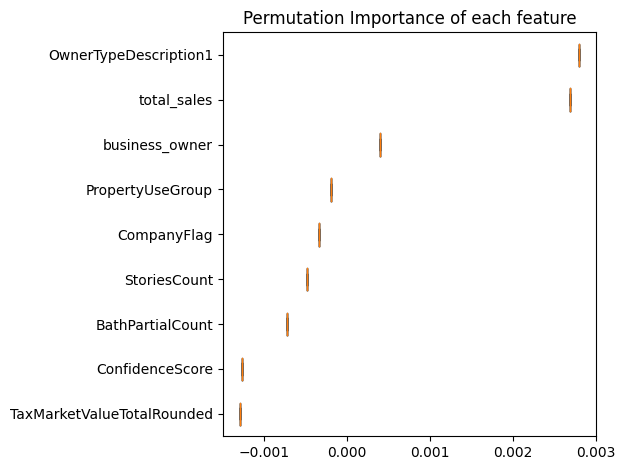

['OwnerTypeDescription1', 'total_sales', 'business_owner', 'PropertyUseGroup', 'CompanyFlag', 'StoriesCount', 'BathPartialCount', 'ConfidenceScore', 'TaxMarketValueTotalRounded']


In [28]:
df_temp = task.df_test.copy()
sale_in_column = "sale_in_3_months"

train_columns = list(task.df_train_classification.drop(columns=task.drop_label_names).columns)
X_temp = df_temp[train_columns].to_numpy()
y_temp = df_temp[sale_in_column].values

model = mlflow.sklearn.load_model(task.model_directories[sale_in_column])
result = permutation_importance(model, X_temp, y_temp, n_repeats=1, n_jobs=3)

fig, ax = plt.subplots()
sorted_idx = result.importances_mean.argsort()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=[train_columns[i] for i in sorted_idx])
ax.set_title("Permutation Importance of each feature")
fig.tight_layout()
plt.show()
    